Imports

In [2]:
# Standard library imports
import os
import re
import unicodedata
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import textstat
from textblob import TextBlob
from textblob_nl import PatternAnalyzer
from tqdm.notebook import tqdm
import requests


### Carsales

extracted from https://opendata.cbs.nl/#/CBS/nl/dataset/85898NED/table?ts=1745764299955

>Dataset inladen 

In [3]:
# Autoverkoop inladen
df_wegvoertuigenRaw = pd.read_csv(
    r"E:\Nieuw dataset\Verkochte wegvoertuigen\Verkochte_wegvoertuigen_Full elektric.csv",
    sep=";"
)

display(df_wegvoertuigenRaw)

,Wegvoertuigen,Brandstofsoort voertuig,Perioden,Totaal verkochte wegvoertuigen (aantal)
0,Totaal wegvoertuigen,Full elektric (BEV),2007 januari,31
1,Totaal wegvoertuigen,Full elektric (BEV),2007 februari,39
2,Totaal wegvoertuigen,Full elektric (BEV),2007 maart,123
3,Totaal wegvoertuigen,Full elektric (BEV),2007 april,62
4,Totaal wegvoertuigen,Full elektric (BEV),2007 mei,84
...,...,...,...,...
214,Totaal wegvoertuigen,Full elektric (BEV),2024 november*,32623
215,Totaal wegvoertuigen,Full elektric (BEV),2024 december*,39594
216,Totaal wegvoertuigen,Full elektric (BEV),2025 januari*,33680
217,Totaal wegvoertuigen,Full elektric (BEV),2025 februari*,29071


>Data opschonen en transformeren: Nederlandse naar Engelse maanden, periode-format, filtering, Mapping van Nederlandse naar Engelse maandnamen

In [4]:
maand_mapping = {
    'januari': 'January',
    'februari': 'February',
    'maart': 'March',
    'april': 'April',
    'mei': 'May',
    'juni': 'June',
    'juli': 'July',
    'augustus': 'August',
    'september': 'September',
    'oktober': 'October',
    'november': 'November',
    'december': 'December'
}

# 1. Sterretjes verwijderen
df_wegvoertuigenRaw['Perioden'] = df_wegvoertuigenRaw['Perioden'].str.replace('*', '', regex=False).str.strip()

# 2. Nederlandse maandnamen vervangen door Engelse
for nl, eng in maand_mapping.items():
    df_wegvoertuigenRaw['Perioden'] = df_wegvoertuigenRaw['Perioden'].str.replace(nl, eng, regex=False)

# 3. Periode omzetten naar datetime
df_wegvoertuigenRaw['Periode'] = pd.to_datetime(df_wegvoertuigenRaw['Perioden'], format='%Y %B', errors='coerce')

# 4. Omzetten naar YYYY/MM string
df_wegvoertuigenRaw['Periode'] = df_wegvoertuigenRaw['Periode'].dt.strftime('%Y/%m')

# 5. Alleen relevante kolommen behouden
df_wegvoertuigen = df_wegvoertuigenRaw[['Periode', 'Totaal verkochte wegvoertuigen (aantal)']]

# 5b. Filter op periode 2015/01 t/m 2025/03
df_wegvoertuigen = df_wegvoertuigen[
    (df_wegvoertuigen['Periode'] >= '2007/01') & 
    (df_wegvoertuigen['Periode'] <= '2025/03')
]

# 6. Kolom hernoemen
df_wegvoertuigen.rename(columns={'Totaal verkochte wegvoertuigen (aantal)': 'Totaal_verkochte_wegvoertuigen'}, inplace=True)

# 7. Resultaat bekijken
display(df_wegvoertuigen)


,Periode,Totaal_verkochte_wegvoertuigen
0,2007/01,31
1,2007/02,39
2,2007/03,123
3,2007/04,62
4,2007/05,84
...,...,...
214,2024/11,32623
215,2024/12,39594
216,2025/01,33680
217,2025/02,29071


> Opslaan als CSV

In [42]:
# Opslaan als CSV
output_path = r"E:\Nieuw dataset\Verkochte wegvoertuigen\df_wegvoertuigen_2007.csv"
df_wegvoertuigen.to_csv(output_path, index=False)

# Pad van de nieuwe CSV printen
print(f"CSV opgeslagen op: {output_path}")

CSV opgeslagen op: E:\Nieuw dataset\Verkochte wegvoertuigen\df_wegvoertuigen_2007.csv


## Google trends:

extracted from https://trends.google.com/trends/explore?cat=47&date=all&geo=NL&q=EV,subsidie%20elektrische%20auto,elektrische%20auto,elektrisch%20rijden

In [3]:
# Autoverkoop inladen
df_trends_Raw = pd.read_csv(
    r"E:\Nieuw dataset\Google trends\samengevoegde_trends.csv",
    sep=","
)

display(df_trends_Raw)

,Date,vraag naar elektrische voertuigen_x,elektrische bussen_x,laadpunten,laadstations,vraag naar elektrische voertuigen_y,uitrol van elektrische voertuigen_x,elektrische bus_x,elektrische bussen_y,plug-in hybride,...,voertuig met verbrandingsmotor,voertuigen met verbrandingsmotor,laders voor lichte voertuigen,wereldwijde elektrische voertuigen,wereldwijde data over elektrische voertuigen,laadnetwerk,thuis opladen,hybride elektrisch,laadpunt,elektrische bus_y
0,2007-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2007-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2007-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2007-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2007-05,0,0,0,0,0,0,28,0,0,...,0,0,0,0,0,0,0,0,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,2024-09,0,0,63,70,0,100,40,0,100,...,0,0,0,0,0,0,57,59,82,40
213,2024-10,0,85,48,62,0,0,69,85,85,...,0,0,0,0,0,0,79,63,71,69
214,2024-11,0,0,47,63,0,0,42,0,57,...,0,0,0,0,0,0,68,46,71,42
215,2024-12,0,82,48,52,0,0,45,82,79,...,0,0,0,0,0,0,69,60,72,45


### Top 3 Corrolerende zoektermen 

In [4]:
df_trends_selected = df_trends_Raw[['Date', 'thuis opladen', 'elektrische auto', 'hybride elektrisch']]
display(df_trends_selected.head())

,Date,thuis opladen,elektrische auto,hybride elektrisch
0,2007-01,0,1,0
1,2007-02,0,0,0
2,2007-03,0,0,0
3,2007-04,0,0,0
4,2007-05,0,2,0


In [5]:

# 6. Kolom hernoemen
df_trends_Raw.rename(columns={'Date': 'Periode'}, inplace=True)


df_trends_Raw['Periode'] = pd.to_datetime(df_trends_Raw['Periode'], format='%Y-%m', errors='coerce')
df_trends_Raw['Periode'] = df_trends_Raw['Periode'].dt.strftime('%Y/%m')



# 5b. Filter op periode 2007/01 t/m 2025/03
df_trends_Raw = df_trends_Raw[
    (df_trends_Raw['Periode'] >= '2007/01') & 
    (df_trends_Raw['Periode'] <= '2025/03') 

]
df_trends = df_trends_Raw[['Periode', 'thuis opladen', 'elektrische auto', 'hybride elektrisch']] 


# 7. Resultaat bekijken
display(df_trends)

,Periode,thuis opladen,elektrische auto,hybride elektrisch
0,2007/01,0,1,0
1,2007/02,0,0,0
2,2007/03,0,0,0
3,2007/04,0,0,0
4,2007/05,0,2,0
...,...,...,...,...
212,2024/09,57,52,59
213,2024/10,79,50,63
214,2024/11,68,48,46
215,2024/12,69,46,60


In [17]:
# Select only the required columns and save to CSV
output_path = r"E:\Nieuw dataset\Google trends\TopTrends_EV_Zoektermen_NL_2007heden.csv"
df_trends = df_trends_Raw[['Periode', 'thuis opladen', 'elektrische auto', 'hybride elektrisch']]
df_trends.to_csv(output_path, index=False)
print(f"CSV opgeslagen op: {output_path}")

CSV opgeslagen op: E:\Nieuw dataset\Google trends\TopTrends_EV_Zoektermen_NL_2007heden.csv


# 1. Consumentenvertrouwen, economisch klimaat, koopbereidheid en gungetijd voor grote aankopen

Extracted from: https://opendata.cbs.nl/#/CBS/nl/dataset/83694NED/table?searchKeywords=%E2%80%93%20consumentenvertrouwen,%20economisch%20klimaat%20en%20koopbereidheid

 > Data inladen/inzien
 
De indicatoren kunnen een waarde aannemen van -100 (iedereen antwoordt negatief) tot +100 (iedereen antwoordt positief). Bij een waarde van 0 is het aandeel pessimisten gelijk aan het aandeel optimisten.


In [2]:

# 1. Data opnieuw inlezen en kolommen hernoemen
df_raw = pd.read_csv(r"E:\Nieuw dataset\Consumentenvertrouwen, economisch klimaat en koopbereidheid ongecorrigeerd\Consumentenvertrouwen_12052025_161612.csv", sep=";")

display(df_raw)

,Perioden,Consumentenvertrouwen (gemiddelde saldo van de deelvragen),Economisch klimaat (gemiddelde saldo van de deelvragen),Koopbereidheid (gemiddelde saldo van de deelvragen),Gunstige tijd voor grote aankopen (saldo positieve en negatieve antwoorden)
0,1986 april,2,6,0,-1
1,1986 mei,8,17,1,-2
2,1986 juni,15,33,3,-5
3,1986 juli,20,45,4,-6
4,1986 augustus,21,47,4,-7
...,...,...,...,...,...
464,2024 december,-26,-45,-13,-27
465,2025 januari,-28,-50,-14,-28
466,2025 februari,-32,-54,-17,-32
467,2025 maart,-34,-57,-18,-34


In [3]:
# Voeg ook 'Consumentenvertrouwen' toe
# Opnieuw laden en verwerken met die kolom erbij
df_raw = pd.read_csv(r"E:\Nieuw dataset\Consumentenvertrouwen, economisch klimaat en koopbereidheid ongecorrigeerd\Consumentenvertrouwen_12052025_161612.csv", sep=";")
# 1. Data opnieuw inlezen en kolommen hernoemen
# Kolommen hernoemen voor eenvoud
df_raw = df_raw.rename(columns={
    'Perioden': 'Periode',
    'Consumentenvertrouwen (gemiddelde saldo van de deelvragen)': 'Consumentenvertrouwen',
    'Economisch klimaat (gemiddelde saldo van de deelvragen)': 'Economisch klimaat',
    'Koopbereidheid (gemiddelde saldo van de deelvragen)': 'Koopbereidheid',
    'Gunstige tijd voor grote aankopen (saldo positieve en negatieve antwoorden)': 'Grote aankopen'
})

# Periode naar datetime
df_raw['Periode'] = pd.to_datetime(df_raw['Periode'], format='%Y %B', errors='coerce')

# Filter op 2007 t/m 2025
df_raw = df_raw[(df_raw['Periode'] >= '2007-01-01') & (df_raw['Periode'] <= '2025-04-01')]

# Waarden numeriek maken
for col in ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen']:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')

# Periode naar string (YYYY/MM)
df_raw['Periode'] = df_raw['Periode'].dt.strftime('%Y/%m')

# Relevante kolommen selecteren
df_clean = df_raw[['Periode', 'Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen']].copy()

# Maandlijst genereren
maanden_volledig = pd.date_range(start='2007-01-01', end='2025-04-01', freq='MS').strftime('%Y/%m')
df_maanden = pd.DataFrame({'Periode': maanden_volledig})

# Merge en interpolatie
df_consumenten_merged = df_maanden.merge(df_clean, on='Periode', how='left')
interpoleer_kolommen = ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen']
df_consumenten_merged[interpoleer_kolommen] = df_consumenten_merged[interpoleer_kolommen].interpolate(method='linear')
df_consumenten_merged[interpoleer_kolommen] = df_consumenten_merged[interpoleer_kolommen].fillna(method='bfill')

# Resultaat tonen
display(df_consumenten_merged)



C:\Users\dylan\AppData\Local\Temp\ipykernel_840\3878508282.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_consumenten_merged[interpoleer_kolommen] = df_consumenten_merged[interpoleer_kolommen].fillna(method='bfill')


,Periode,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen
0,2007/01,20.00,37.0,9.00,8.00
1,2007/02,20.00,37.0,9.00,8.00
2,2007/03,20.00,37.0,9.00,8.00
3,2007/04,20.00,37.0,9.00,8.00
4,2007/05,18.00,32.0,9.00,7.40
...,...,...,...,...,...
215,2024/12,-26.00,-45.0,-13.00,-27.00
216,2025/01,-28.75,-49.0,-14.75,-28.75
217,2025/02,-31.50,-53.0,-16.50,-30.50
218,2025/03,-34.25,-57.0,-18.25,-32.25


Check if no missing months/values

In [4]:
# Controleer of alle maanden tussen 2015/01 en 2025/04 aanwezig zijn
verwachte_maanden = pd.date_range(start='2007-01-01', end='2025-01-31', freq='MS').strftime('%Y/%m')
ontbrekende_maanden = set(verwachte_maanden) - set(df_consumenten_merged['Periode'])

# Controleer op ontbrekende waarden (NaN's)
ontbrekende_waarden = df_consumenten_merged.isna().sum()

ontbrekende_maanden, ontbrekende_waarden


(set(),
 Periode                  0
 Consumentenvertrouwen    0
 Economisch klimaat       0
 Koopbereidheid           0
 Grote aankopen           0
 dtype: int64)

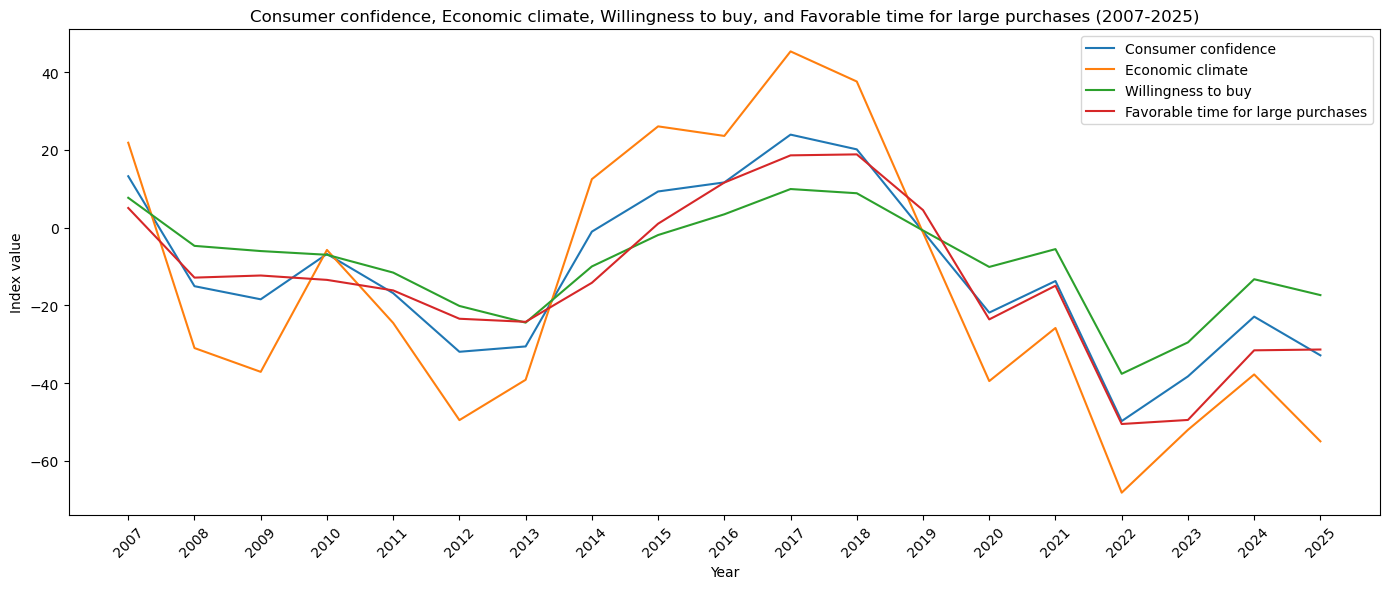

In [6]:
# Extract year from 'Periode'
df_consumenten_merged['Year'] = df_consumenten_merged['Periode'].str[:4]

# Group by year and calculate the mean for each indicator
df_yearly = df_consumenten_merged.groupby('Year')[['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen']].mean().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(df_yearly['Year'], df_yearly['Consumentenvertrouwen'], label='Consumer confidence')
plt.plot(df_yearly['Year'], df_yearly['Economisch klimaat'], label='Economic climate')
plt.plot(df_yearly['Year'], df_yearly['Koopbereidheid'], label='Willingness to buy')
plt.plot(df_yearly['Year'], df_yearly['Grote aankopen'], label='Favorable time for large purchases')
plt.xlabel('Year')
plt.ylabel('Index value')
plt.title('Consumer confidence, Economic climate, Willingness to buy, and Favorable time for large purchases (2007-2025)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

>CSV Opslaan

In [52]:
display(df_consumenten_merged)

# Opslaan als CSV
output_path = r"E:\Nieuw dataset\Consumentenvertrouwen, economisch klimaat en koopbereidheid ongecorrigeerd\consumentenvertrouwen_2007_Merged.csv"
df_consumenten_merged.to_csv(output_path, index=False)

# Pad van de nieuwe CSV printen
print(f"CSV opgeslagen op: {output_path}")


,Periode,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen
0,2007/01,20.00,37.0,9.00,8.00
1,2007/02,20.00,37.0,9.00,8.00
2,2007/03,20.00,37.0,9.00,8.00
3,2007/04,20.00,37.0,9.00,8.00
4,2007/05,18.00,32.0,9.00,7.40
...,...,...,...,...,...
215,2024/12,-26.00,-45.0,-13.00,-27.00
216,2025/01,-28.75,-49.0,-14.75,-28.75
217,2025/02,-31.50,-53.0,-16.50,-30.50
218,2025/03,-34.25,-57.0,-18.25,-32.25


CSV opgeslagen op: E:\Nieuw dataset\Consumentenvertrouwen, economisch klimaat en koopbereidheid ongecorrigeerd\consumentenvertrouwen_2007_Merged.csv


>  Data opschonen 


-  perioden wijzigen naar yy/mm 
- datum selecteren 2015-1 t/m 2025-01

> Data wordt weergeven in kwartalen, ga ervoor kiezen om Interpolatie toe te voegen 

> Data exporteren naar csv

# Pompprijzen motorbrandstoffen

Extracted from: https://opendata.cbs.nl/#/CBS/nl/dataset/80416ned/table?ts=1745763454832 

In [16]:
# Dataset 2 inladen
df_pompprijzen = pd.read_csv(
    r"E:\Nieuw dataset\CBS POMPPRIJZEN\nEWPompprijzen_motorbrandstoffen__brandstofsoort__per_dag_12052025_154757.csv",
    sep=";",
   
)
display(df_pompprijzen)


,ID,Perioden,BenzineEuro95_1,Diesel_2
0,0,20060101,1.325,1.003
1,1,20060102,1.328,1.007
2,2,20060103,1.332,1.007
3,3,20060104,1.348,1.020
4,4,20060105,1.347,1.021
...,...,...,...,...
7060,7060,20250501,1.871,1.599
7061,7061,20250502,1.868,1.594
7062,7062,20250503,1.858,1.585
7063,7063,20250504,1.859,1.583


> Data inladen/inzien

In [17]:
# Stap 1: Zet 'Perioden' om naar datetime met expliciet format
df_pompprijzen['Perioden'] = pd.to_datetime(df_pompprijzen['Perioden'], format='%Y%m%d', errors='coerce')

# Stap 2: Filter op gewenste periode
df_pompprijzen = df_pompprijzen[
    (df_pompprijzen['Perioden'] >= '2007-01-01') &
    (df_pompprijzen['Perioden'] <= '2025-03-31')
]

# Stap 3: Zet datum om naar maandformaat YYYY/MM (direct goed)
df_pompprijzen['Periode'] = df_pompprijzen['Perioden'].dt.strftime('%Y/%m')

display(df_pompprijzen)

C:\Users\dylan\AppData\Local\Temp\ipykernel_79836\2583476780.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pompprijzen['Periode'] = df_pompprijzen['Perioden'].dt.strftime('%Y/%m')


,ID,Perioden,BenzineEuro95_1,Diesel_2,Periode
365,365,2007-01-01,1.318,0.992,2007/01
366,366,2007-01-02,1.319,0.993,2007/01
367,367,2007-01-03,1.324,0.993,2007/01
368,368,2007-01-04,1.326,0.992,2007/01
369,369,2007-01-05,1.322,0.988,2007/01
...,...,...,...,...,...
7025,7025,2025-03-27,1.895,1.658,2025/03
7026,7026,2025-03-28,1.903,1.660,2025/03
7027,7027,2025-03-29,1.910,1.662,2025/03
7028,7028,2025-03-30,1.913,1.664,2025/03


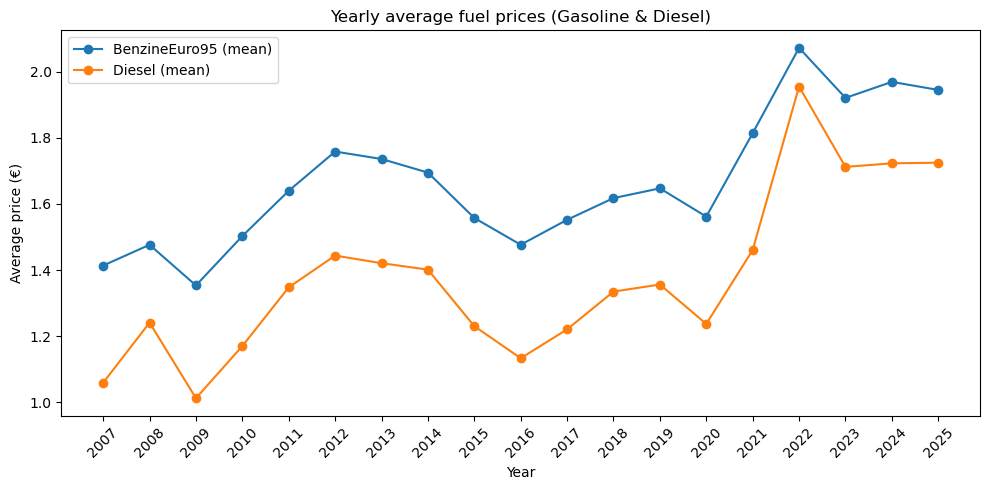

In [20]:
# Extract year from 'Periode' and calculate yearly mean
df_pompprijzen_aggregatie['Year'] = df_pompprijzen_aggregatie['Periode'].str[:4].astype(int)
df_yearly = df_pompprijzen_aggregatie.groupby('Year')[['BenzineEuro95_1_mean', 'Diesel_2_mean']].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(df_yearly['Year'], df_yearly['BenzineEuro95_1_mean'], marker='o', label='BenzineEuro95 (mean)')
plt.plot(df_yearly['Year'], df_yearly['Diesel_2_mean'], marker='o', label='Diesel (mean)')
plt.xlabel('Year')
plt.ylabel('Average price (€)')
plt.title('Yearly average fuel prices (Gasoline & Diesel)')
plt.xticks(df_yearly['Year'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [150]:


# Stap 4: Maandgemiddelde berekenen
df_maandelijks = df_pompprijzen.groupby('Periode')[
    ['BenzineEuro95_1', 'Diesel_2']
].mean().reset_index()

# Stap 5: Extra statistieken per maand
df_pompprijzen_aggregatie = df_pompprijzen.groupby('Periode').agg({
    'BenzineEuro95_1': ['first', 'last', 'min', 'max', 'mean'],
    'Diesel_2': ['first', 'last', 'min', 'max', 'mean']
}).reset_index()

# Stap 6: Kolomnamen netjes maken
df_pompprijzen_aggregatie.columns = ['Periode'] + [
    f'{brandstof}_{stat}' for brandstof, stat in df_pompprijzen_aggregatie.columns.tolist()[1:]
]

# Stap 3: Zet datum om naar maandformaat YYYY/MM
df_pompprijzen['Periode'] = df_pompprijzen['Perioden'].dt.strftime('%Y/%m')

display(df_pompprijzen_aggregatie)



,Periode,BenzineEuro95_1_first,BenzineEuro95_1_last,BenzineEuro95_1_min,BenzineEuro95_1_max,BenzineEuro95_1_mean,Diesel_2_first,Diesel_2_last,Diesel_2_min,Diesel_2_max,Diesel_2_mean
0,2007/01,1.318,1.301,1.283,1.326,1.303032,0.992,0.969,0.955,0.993,0.970000
1,2007/02,1.307,1.362,1.307,1.362,1.325357,0.977,1.003,0.977,1.003,0.990000
2,2007/03,1.365,1.416,1.361,1.416,1.379032,1.003,1.038,0.995,1.038,1.006323
3,2007/04,1.414,1.450,1.410,1.451,1.426500,1.036,1.026,1.019,1.039,1.030600
4,2007/05,1.452,1.463,1.449,1.483,1.466516,1.028,1.037,1.021,1.047,1.032323
...,...,...,...,...,...,...,...,...,...,...,...
214,2024/11,1.914,1.955,1.912,1.986,1.947800,1.652,1.744,1.648,1.774,1.716167
215,2024/12,1.953,1.942,1.940,1.958,1.947871,1.740,1.720,1.716,1.748,1.725774
216,2025/01,1.942,1.960,1.942,1.979,1.960935,1.719,1.752,1.719,1.785,1.753516
217,2025/02,1.959,1.953,1.953,1.978,1.967714,1.744,1.730,1.730,1.750,1.742036


In [151]:
# Controleer of alle maanden tussen 2007/01 en 2025/04 aanwezig zijn in df_consumenten_merged
verwachte_maanden = pd.date_range(start='2007-01-01', end='2025-04-01', freq='MS').strftime('%Y/%m')
ontbrekende_maanden = set(verwachte_maanden) - set(df_consumenten_merged['Periode'])

# Controleer op ontbrekende waarden (NaN's)
ontbrekende_waarden = df_consumenten_merged.isna().sum()

print("Ontbrekende maanden:", ontbrekende_maanden)
print("Ontbrekende waarden per kolom:\n", ontbrekende_waarden)

Ontbrekende maanden: set()
Ontbrekende waarden per kolom:
 Periode                  0
Consumentenvertrouwen    0
Economisch klimaat       0
Koopbereidheid           0
Grote aankopen           0
dtype: int64


 >Data opschonen 

-  perioden wijzigen naar yy/mm 
- datum selecteren 2015-1 t/m 2025-01

> - Perioden omzetten naar per maand (first, last, min, mean, avg voor benzine en diesel)

> Export CSV

In [152]:
# Opslaan als CSV
output_path = r"E:\Nieuw dataset\CBS POMPPRIJZEN\df_pomprijzen_Nieuwaggregatie.csv"
df_pompprijzen_aggregatie.to_csv(output_path, index=False)

# Pad van de nieuwe CSV printen
print(f"CSV opgeslagen op: {output_path}")

CSV opgeslagen op: E:\Nieuw dataset\CBS POMPPRIJZEN\df_pomprijzen_Nieuwaggregatie.csv


## Bijtelling

In [3]:


# Define the bijtelling percentage per year
bijtelling_rules = [
    (2007, 2007, 22),
    (2008, 2009, 14),
    (2010, 2013, 0),
    (2014, 2016, 4),
    (2017, 2018, 4),
    (2019, 2019, 4),
    (2020, 2020, 8),
    (2021, 2021, 12),
    (2022, 2024, 16),
    (2025, 2025, 17),
]

# Generate all months from Jan 2007 to Dec 2025
months = pd.date_range(start='2007-01-01', end='2025-12-01', freq='MS')

# Assign bijtelling percentage based on year
bijtelling_list = []
for dt in months:
    bijtelling = None
    for start, end, pct in bijtelling_rules:
        if start <= dt.year <= end:
            bijtelling = pct
            break
    bijtelling_list.append({
        'Periode': dt.strftime('%Y/%m'),
        'Bijtelling (%)': bijtelling
    })

# Create and display the DataFrame
df_bijtelling_table = pd.DataFrame(bijtelling_list)
display(df_bijtelling_table)


,Periode,Bijtelling (%)
0,2007/01,22
1,2007/02,22
2,2007/03,22
3,2007/04,22
4,2007/05,22
...,...,...
223,2025/08,17
224,2025/09,17
225,2025/10,17
226,2025/11,17


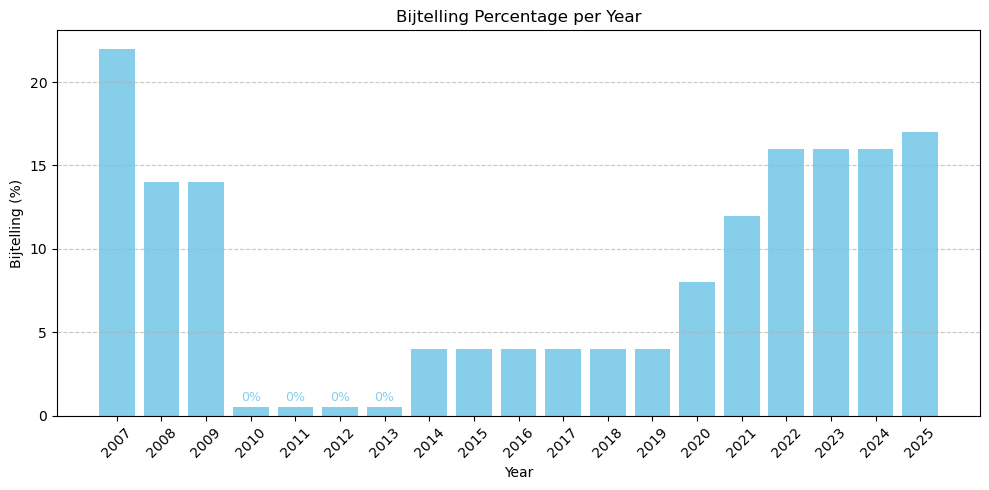

In [7]:
# Create yearly_bijtelling by taking the first bijtelling percentage for each year
df_bijtelling_table['Year'] = df_bijtelling_table['Periode'].str[:4].astype(int)
yearly_bijtelling = df_bijtelling_table.groupby('Year')['Bijtelling (%)'].first().reset_index()

# Ensure yearly_bijtelling['Year'] is str or int for plotting
years = yearly_bijtelling['Year']
percentages = yearly_bijtelling['Bijtelling (%)']

# Set a minimum bar height for 0% years
min_height = 0.5
bar_heights = [min_height if pct == 0 else pct for pct in percentages]
colors = ['skyblue' if pct == 0 else 'skyblue' for pct in percentages]

plt.figure(figsize=(10, 5))
bars = plt.bar(years, bar_heights, color=colors)

# Optionally, add a label "0%" above the small bars
for i, pct in enumerate(percentages):
    if pct == 0:
        plt.text(years.iloc[i], min_height + 0.2, "0%", ha='center', va='bottom', color='skyblue', fontsize=9)

plt.xlabel('Year')
plt.ylabel('Bijtelling (%)')
plt.title('Bijtelling Percentage per Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()

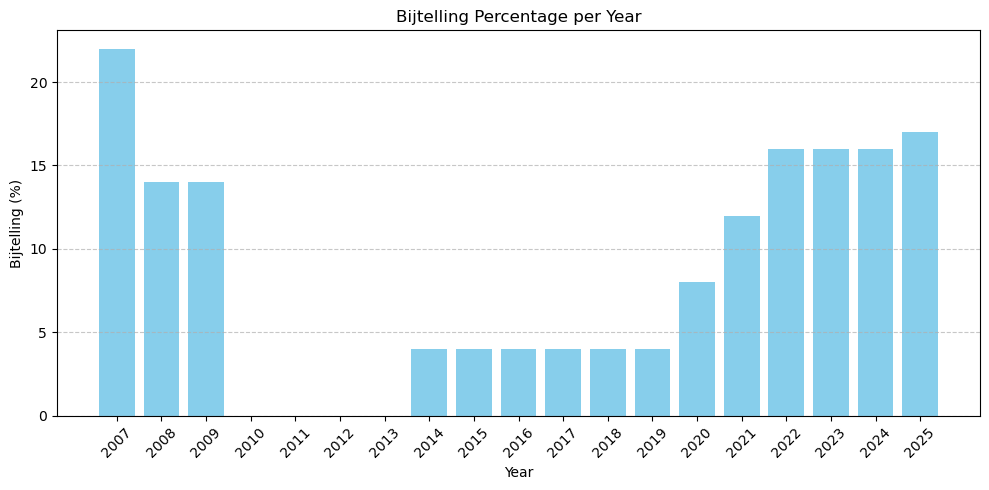

In [ ]:
# Plot the bijtelling percentage for each year as a bar chart, highlighting 0% in a different color
colors = ['red' if pct == 0 else 'skyblue' for pct in yearly_bijtelling['Bijtelling (%)']]

plt.figure(figsize=(10, 5))
plt.bar(yearly_bijtelling['Year'], yearly_bijtelling['Bijtelling (%)'], color=colors)
plt.xlabel('Year')
plt.ylabel('Bijtelling (%)')
plt.title('Bijtelling Percentage per Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(yearly_bijtelling['Year'], rotation=45)
plt.tight_layout()
plt.show()


In [7]:
# Sla alleen 'Periode' en 'Bijtellingspercentage' op als nieuwe CSV
bijtelling_output_path = r"E:\Nieuw dataset\Bijtelling\bijtelling_periode_percentage1.csv"
df_bijtelling_table.to_csv(bijtelling_output_path, index=False)
print(f"CSV opgeslagen op: {bijtelling_output_path}")

CSV opgeslagen op: E:\Nieuw dataset\Bijtelling\bijtelling_periode_percentage1.csv


Loading

In [8]:
df_wegvoertuigen = pd.read_csv(r"E:\Nieuw dataset\Verkochte wegvoertuigen\df_wegvoertuigen_2007.csv", sep=",")
df_bijtelling_percentage = pd.read_csv(r"E:\Nieuw dataset\Bijtelling\bijtelling_periode_percentage1.csv")
df_pompprijzen_aggregatie = pd.read_csv(r"E:\Nieuw dataset\CBS POMPPRIJZEN\df_pomprijzen_Nieuwaggregatie.csv", sep=",")
df_trends = pd.read_csv(r"E:\Nieuw dataset\Google trends\TopTrends_EV_Zoektermen_NL_2007heden.csv", sep=",")
df_consumentenvertrouwen_merged = pd.read_csv(
    r"E:\Nieuw dataset\Consumentenvertrouwen, economisch klimaat en koopbereidheid ongecorrigeerd\consumentenvertrouwen_2007_Merged.csv",
    sep=","
)



### Join both datasets on periode

In [10]:
# Join Google Trends, Wegvoertuigen, Bijtelling, Consumentenvertrouwen en Pompprijzen op 'Periode'
df_trends_wegvoertuigen = pd.merge(df_trends, df_wegvoertuigen, on='Periode', how='left')
df_trends_wegvoertuigen = pd.merge(df_trends_wegvoertuigen, df_bijtelling_percentage[['Periode', 'Bijtelling (%)']], on='Periode', how='left')
df_trends_wegvoertuigen = pd.merge(df_trends_wegvoertuigen, df_consumentenvertrouwen_merged, on='Periode', how='left')
df_trends_wegvoertuigen = pd.merge(df_trends_wegvoertuigen, df_pompprijzen_aggregatie, on='Periode', how='left')

# Zet 'Totaal_verkochte_wegvoertuigen' als laatste kolom
kolommen = [col for col in df_trends_wegvoertuigen.columns if col != 'Totaal_verkochte_wegvoertuigen'] + ['Totaal_verkochte_wegvoertuigen']
df_trends_wegvoertuigen = df_trends_wegvoertuigen[kolommen]

# Resultaat bekijken
display(df_trends_wegvoertuigen)

# Controleer op ontbrekende waarden in de samengevoegde dataset
missing_values = df_trends_wegvoertuigen.isnull().sum()
print("Ontbrekende waarden per kolom:\n", missing_values)


,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtelling (%),Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,BenzineEuro95_1_last,BenzineEuro95_1_min,BenzineEuro95_1_max,BenzineEuro95_1_mean,Diesel_2_first,Diesel_2_last,Diesel_2_min,Diesel_2_max,Diesel_2_mean,Totaal_verkochte_wegvoertuigen
0,2007/01,0,1,0,22,20.00,37.0,9.00,8.00,1.318,1.301,1.283,1.326,1.303032,0.992,0.969,0.955,0.993,0.970000,31
1,2007/02,0,0,0,22,20.00,37.0,9.00,8.00,1.307,1.362,1.307,1.362,1.325357,0.977,1.003,0.977,1.003,0.990000,39
2,2007/03,0,0,0,22,20.00,37.0,9.00,8.00,1.365,1.416,1.361,1.416,1.379032,1.003,1.038,0.995,1.038,1.006323,123
3,2007/04,0,0,0,22,20.00,37.0,9.00,8.00,1.414,1.450,1.410,1.451,1.426500,1.036,1.026,1.019,1.039,1.030600,62
4,2007/05,0,2,0,22,18.00,32.0,9.00,7.40,1.452,1.463,1.449,1.483,1.466516,1.028,1.037,1.021,1.047,1.032323,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,2024/09,57,52,59,16,-21.00,-37.0,-11.00,-29.00,1.912,1.861,1.859,1.916,1.879633,1.635,1.589,1.584,1.640,1.607667,28820
213,2024/10,79,50,63,16,-23.00,-40.0,-11.50,-28.50,1.860,1.914,1.859,1.926,1.902806,1.588,1.649,1.587,1.660,1.640419,30491
214,2024/11,68,48,46,16,-25.00,-43.0,-12.00,-28.00,1.914,1.955,1.912,1.986,1.947800,1.652,1.744,1.648,1.774,1.716167,32623
215,2024/12,69,46,60,16,-26.00,-45.0,-13.00,-27.00,1.953,1.942,1.940,1.958,1.947871,1.740,1.720,1.716,1.748,1.725774,39594


Ontbrekende waarden per kolom:
 Periode                           0
thuis opladen                     0
elektrische auto                  0
hybride elektrisch                0
Bijtelling (%)                    0
Consumentenvertrouwen             0
Economisch klimaat                0
Koopbereidheid                    0
Grote aankopen                    0
BenzineEuro95_1_first             0
BenzineEuro95_1_last              0
BenzineEuro95_1_min               0
BenzineEuro95_1_max               0
BenzineEuro95_1_mean              0
Diesel_2_first                    0
Diesel_2_last                     0
Diesel_2_min                      0
Diesel_2_max                      0
Diesel_2_mean                     0
Totaal_verkochte_wegvoertuigen    0
dtype: int64


In [156]:
# Print all rows in df_trends_wegvoertuigen that contain any NaN values
nan_rows = df_trends_wegvoertuigen[df_trends_wegvoertuigen.isna().any(axis=1)]
print(nan_rows)

Empty DataFrame
Columns: [Periode, EV: (Nederland), subsidie elektrische auto: (Nederland), elektrische auto: (Nederland), elektrisch rijden: (Nederland), Bijtellingspercentage, Consumentenvertrouwen, Economisch klimaat, Koopbereidheid, Grote aankopen, BenzineEuro95_1_first, BenzineEuro95_1_last, BenzineEuro95_1_min, BenzineEuro95_1_max, BenzineEuro95_1_mean, Diesel_2_first, Diesel_2_last, Diesel_2_min, Diesel_2_max, Diesel_2_mean, Totaal_verkochte_wegvoertuigen]
Index: []

[0 rows x 21 columns]


In [11]:
# Opslaan van df_trends_wegvoertuigen als CSV
output_joined_path = r"E:\Nieuw dataset\Joined trends\joined_trend_sales_All1.csv"
df_trends_wegvoertuigen.to_csv(output_joined_path, index=False)
print(f"CSV opgeslagen op: {output_joined_path}")

CSV opgeslagen op: E:\Nieuw dataset\Joined trends\joined_trend_sales_All1.csv


In [22]:
# Create a table with variable name, description, and datatype for df_trends_wegvoertuigen
variable_info = [
    ("Periode", "Period (YYYY/MM)", "str"),
    ("thuis opladen", "Google Trends score for 'thuis opladen' (charging at home)", "int"),
    ("elektrische auto", "Google Trends score for 'elektrische auto' (electric car)", "int"),
    ("hybride elektrisch", "Google Trends score for 'hybride elektrisch' (hybrid electric)", "int"),
    ("Bijtellingspercentage", "Addition percentage for company car tax", "int"),
    ("Consumentenvertrouwen", "Consumer confidence index", "float"),
    ("Economisch klimaat", "Economic climate index", "float"),
    ("Koopbereidheid", "Willingness to buy index", "float"),
    ("Grote aankopen", "Favorable time for large purchases index", "float"),
    ("BenzineEuro95_1_first", "First recorded price of Euro95 gasoline in month", "float"),
    ("BenzineEuro95_1_last", "Last recorded price of Euro95 gasoline in month", "float"),
    ("BenzineEuro95_1_min", "Minimum price of Euro95 gasoline in month", "float"),
    ("BenzineEuro95_1_max", "Maximum price of Euro95 gasoline in month", "float"),
    ("BenzineEuro95_1_mean", "Mean price of Euro95 gasoline in month", "float"),
    ("Diesel_2_first", "First recorded price of Diesel in month", "float"),
    ("Diesel_2_last", "Last recorded price of Diesel in month", "float"),
    ("Diesel_2_min", "Minimum price of Diesel in month", "float"),
    ("Diesel_2_max", "Maximum price of Diesel in month", "float"),
    ("Diesel_2_mean", "Mean price of Diesel in month", "float"),
    ("Totaal_verkochte_wegvoertuigen", "Total number of sold vehicles (all types)", "int"),
]

df_variable_info = pd.DataFrame(variable_info, columns=["Variable Name", "Description", "Data Type"])
display(df_variable_info)

,Variable Name,Description,Data Type
0,Periode,Period (YYYY/MM),str
1,thuis opladen,Google Trends score for 'thuis opladen' (charg...,int
2,elektrische auto,Google Trends score for 'elektrische auto' (el...,int
3,hybride elektrisch,Google Trends score for 'hybride elektrisch' (...,int
4,Bijtellingspercentage,Addition percentage for company car tax,int
5,Consumentenvertrouwen,Consumer confidence index,float
6,Economisch klimaat,Economic climate index,float
7,Koopbereidheid,Willingness to buy index,float
8,Grote aankopen,Favorable time for large purchases index,float
9,BenzineEuro95_1_first,First recorded price of Euro95 gasoline in month,float


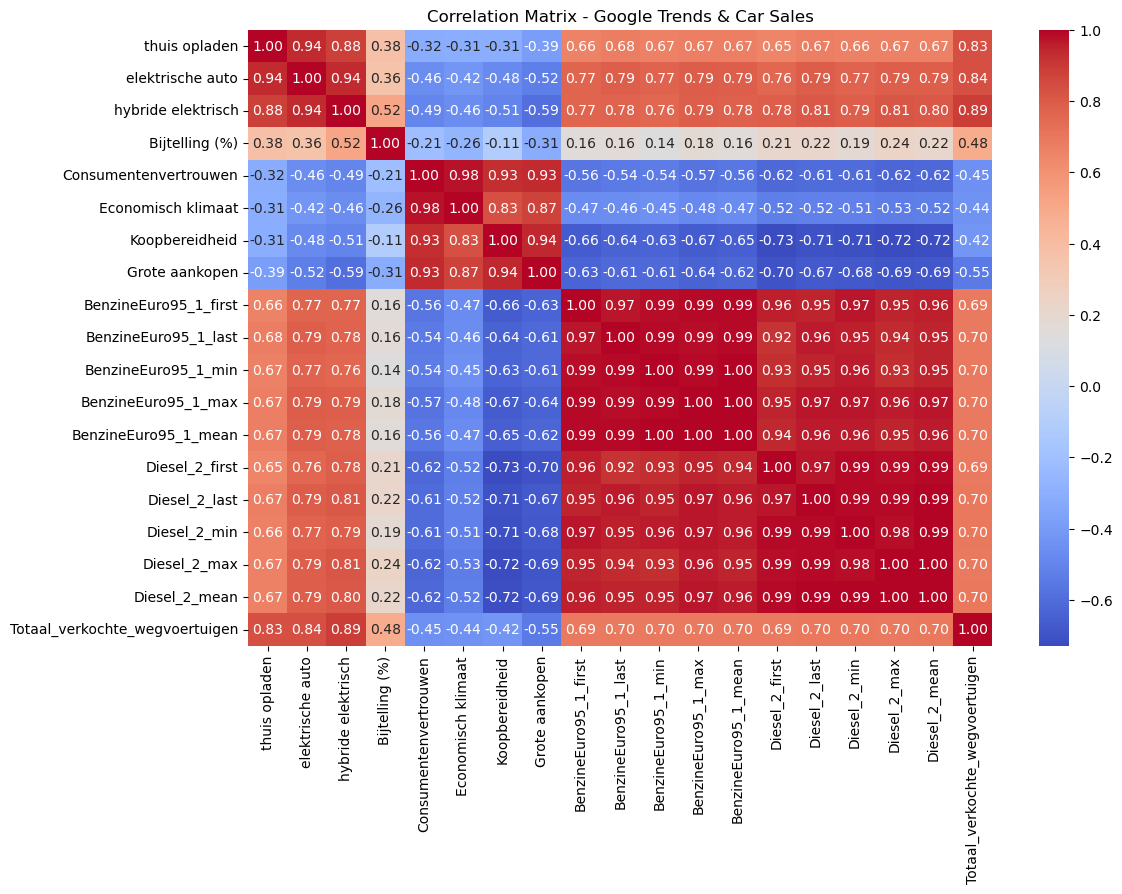

In [12]:
# Correlation matrix plot (exclude non-numeric columns)
plt.figure(figsize=(12, 8))
corr = df_trends_wegvoertuigen.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - Google Trends & Car Sales')
plt.show()

# # Scatter plot: EV search interest vs. car sales
# plt.figure(figsize=(8, 6))
# sns.scatterplot(
#     data=df_trends_wegvoertuigen,
#     x='EV: (Nederland)',
#     y='Totaal_verkochte_wegvoertuigen'
# )
# plt.xlabel('Google Trends: EV (Nederland)')
# plt.ylabel('Totaal verkochte wegvoertuigen')
# plt.title('EV Search Interest vs. Car Sales')
# plt.show()

# Lag 
x month lag time


In [6]:
df_trends_wegvoertuigen = pd.read_csv(r"E:\Nieuw dataset\Joined trends\joined_trend_sales_All.csv")
display(df_trends_wegvoertuigen)

,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtellingspercentage,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,BenzineEuro95_1_last,BenzineEuro95_1_min,BenzineEuro95_1_max,BenzineEuro95_1_mean,Diesel_2_first,Diesel_2_last,Diesel_2_min,Diesel_2_max,Diesel_2_mean,Totaal_verkochte_wegvoertuigen
0,2007/01,0,1,0,0,20.00,37.0,9.00,8.00,1.318,1.301,1.283,1.326,1.303032,0.992,0.969,0.955,0.993,0.970000,31
1,2007/02,0,0,0,0,20.00,37.0,9.00,8.00,1.307,1.362,1.307,1.362,1.325357,0.977,1.003,0.977,1.003,0.990000,39
2,2007/03,0,0,0,0,20.00,37.0,9.00,8.00,1.365,1.416,1.361,1.416,1.379032,1.003,1.038,0.995,1.038,1.006323,123
3,2007/04,0,0,0,0,20.00,37.0,9.00,8.00,1.414,1.450,1.410,1.451,1.426500,1.036,1.026,1.019,1.039,1.030600,62
4,2007/05,0,2,0,0,18.00,32.0,9.00,7.40,1.452,1.463,1.449,1.483,1.466516,1.028,1.037,1.021,1.047,1.032323,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,2024/09,57,52,59,16,-21.00,-37.0,-11.00,-29.00,1.912,1.861,1.859,1.916,1.879633,1.635,1.589,1.584,1.640,1.607667,28820
213,2024/10,79,50,63,16,-23.00,-40.0,-11.50,-28.50,1.860,1.914,1.859,1.926,1.902806,1.588,1.649,1.587,1.660,1.640419,30491
214,2024/11,68,48,46,16,-25.00,-43.0,-12.00,-28.00,1.914,1.955,1.912,1.986,1.947800,1.652,1.744,1.648,1.774,1.716167,32623
215,2024/12,69,46,60,16,-26.00,-45.0,-13.00,-27.00,1.953,1.942,1.940,1.958,1.947871,1.740,1.720,1.716,1.748,1.725774,39594


In [8]:
df = df_trends_wegvoertuigen.copy()
# The 'Periode' column is in 'YYYY/MM' format, so use the correct format string
df['Periode'] = pd.to_datetime(df['Periode'], format='%Y/%m')
df = df.sort_values('Periode').reset_index(drop=True)

# Define lag settings
sales_lag = 4
google_lag = 0

# Define columns
target_cols = ['Totaal_verkochte_wegvoertuigen']
google_trend_cols = ['thuis opladen', 'elektrische auto', 'hybride elektrisch']

# Apply lag for car sales (6 months)
for col in target_cols:
    for lag in range(1, sales_lag + 1):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Apply lag for Google Trends (4 months)
for col in google_trend_cols:
    for lag in range(1, google_lag + 1):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Drop rows with NaNs
df_lagged = df.dropna().reset_index(drop=True)


display(df_lagged)


,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtellingspercentage,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,...,Diesel_2_first,Diesel_2_last,Diesel_2_min,Diesel_2_max,Diesel_2_mean,Totaal_verkochte_wegvoertuigen,Totaal_verkochte_wegvoertuigen_lag1,Totaal_verkochte_wegvoertuigen_lag2,Totaal_verkochte_wegvoertuigen_lag3,Totaal_verkochte_wegvoertuigen_lag4
0,2007-05-01,0,2,0,0,18.00,32.0,9.00,7.40,1.452,...,1.028,1.037,1.021,1.047,1.032323,84,62.0,123.0,39.0,31.0
1,2007-06-01,0,2,0,0,16.00,27.0,9.00,6.80,1.458,...,1.035,1.057,1.035,1.066,1.053433,112,84.0,62.0,123.0,39.0
2,2007-07-01,0,1,0,0,14.00,22.0,9.00,6.20,1.451,...,1.057,1.064,1.057,1.069,1.063484,124,112.0,84.0,62.0,123.0
3,2007-08-01,0,1,0,0,12.00,17.0,9.00,5.60,1.415,...,1.066,1.055,1.045,1.068,1.052387,96,124.0,112.0,84.0,62.0
4,2007-09-01,0,1,0,0,10.00,12.0,9.00,5.00,1.422,...,1.056,1.090,1.056,1.094,1.081133,120,96.0,124.0,112.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,2024-09-01,57,52,59,16,-21.00,-37.0,-11.00,-29.00,1.912,...,1.635,1.589,1.584,1.640,1.607667,28820,23683.0,25370.0,27731.0,26607.0
209,2024-10-01,79,50,63,16,-23.00,-40.0,-11.50,-28.50,1.860,...,1.588,1.649,1.587,1.660,1.640419,30491,28820.0,23683.0,25370.0,27731.0
210,2024-11-01,68,48,46,16,-25.00,-43.0,-12.00,-28.00,1.914,...,1.652,1.744,1.648,1.774,1.716167,32623,30491.0,28820.0,23683.0,25370.0
211,2024-12-01,69,46,60,16,-26.00,-45.0,-13.00,-27.00,1.953,...,1.740,1.720,1.716,1.748,1.725774,39594,32623.0,30491.0,28820.0,23683.0


> Save as CSV

In [88]:
output_lagged_path = r"E:\Nieuw dataset\Timeseriessplit\evsales_trends_lagged_sales2_google0.csv"   

df_lagged.to_csv(output_lagged_path, index=False)
print(f"CSV opgeslagen op: {output_lagged_path}")
 

CSV opgeslagen op: E:\Nieuw dataset\Timeseriessplit\evsales_trends_lagged_sales2_google0.csv
